In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import pandas as pd

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [3]:
# Data Preprocessing: Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Load the Dataset (Replace 'path_to_train', 'path_to_val' and 'path_to_test' with the actual paths)
train_dataset = datasets.ImageFolder(root='../Datasets/datasets/train', transform=transform)
val_dataset = datasets.ImageFolder(root='../Datasets/datasets/val', transform=transform)
test_dataset = datasets.ImageFolder(root='../Datasets/datasets/test', transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

In [4]:
# Define the Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)  # Adjusted for new image size
        self.fc2 = nn.Linear(512, 2)  # Only two output classes (cat or dog)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)  # Flatten the output
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
# Instantiate the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_predictions = []  # Store predictions and actual labels for training
    actual_train_labels = []
    train_ids = []  # To store image IDs for the training set
    val_predictions = []    # Store predictions for validation
    actual_val_labels = []  # Store actual labels for validation
    val_ids = []  # To store image IDs for the validation set

    for epoch in range(num_epochs):
        running_loss = 0.0
        val_loss = 0.0
        val_accuracy = 0.0
        
        # Training phase
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Capture the image IDs for the current batch
            ids = [os.path.basename(train_loader.dataset.imgs[i][0]) for i in range(batch_idx * train_loader.batch_size, (batch_idx + 1) * train_loader.batch_size)]
            train_ids.extend(ids)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            # Collect predictions
            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            actual_train_labels.extend(labels.cpu().numpy())
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Capture the image IDs for the validation set
                ids = [os.path.basename(val_loader.dataset.imgs[i][0]) for i in range(total, total + len(labels))]
                val_ids.extend(ids)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Collect validation predictions
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                val_predictions.extend(predicted.cpu().numpy())
                actual_val_labels.extend(labels.cpu().numpy())
        
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        model.train()

    return train_ids, actual_train_labels, train_predictions, val_ids, actual_val_labels, val_predictions

# Evaluation function for test dataset
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actual_labels = []
    test_ids = []  # To store image IDs for the test set
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Capture the image IDs for the test set
            ids = [os.path.basename(test_loader.dataset.imgs[i][0]) for i in range(len(labels))]
            test_ids.extend(ids)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * sum(predictions[i] == actual_labels[i] for i in range(len(predictions))) / len(actual_labels)
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    return test_ids, actual_labels, predictions

In [6]:
# Train the model with validation set and get results
#actual_train_labels, train_predictions, actual_val_labels, val_predictions = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1)

# Evaluate the model on the test set
#actual_test_labels, test_predictions = evaluate_model(model, test_loader)

# Train the model with validation set and get results
train_ids, actual_train_labels, train_predictions, val_ids, actual_val_labels, val_predictions = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Evaluate the model on the test set
test_ids, actual_test_labels, test_predictions = evaluate_model(model, test_loader)

Epoch [1/10], Training Loss: 0.5743, Validation Loss: 0.5286, Validation Accuracy: 73.26%
Epoch [2/10], Training Loss: 0.4677, Validation Loss: 0.4618, Validation Accuracy: 78.04%
Epoch [3/10], Training Loss: 0.4023, Validation Loss: 0.4829, Validation Accuracy: 77.22%
Epoch [4/10], Training Loss: 0.3323, Validation Loss: 0.4818, Validation Accuracy: 78.82%
Epoch [5/10], Training Loss: 0.2330, Validation Loss: 0.5285, Validation Accuracy: 78.58%
Epoch [6/10], Training Loss: 0.1317, Validation Loss: 0.6353, Validation Accuracy: 78.80%
Epoch [7/10], Training Loss: 0.0748, Validation Loss: 0.7358, Validation Accuracy: 78.50%
Epoch [8/10], Training Loss: 0.0521, Validation Loss: 0.8565, Validation Accuracy: 78.98%
Epoch [9/10], Training Loss: 0.0369, Validation Loss: 0.9651, Validation Accuracy: 78.94%
Epoch [10/10], Training Loss: 0.0321, Validation Loss: 1.1199, Validation Accuracy: 78.94%
Test Accuracy: 80.60%


In [7]:
# Create DataFrames for train, validation, and test results including image IDs
#train_ids = [os.path.basename(train_dataset.imgs[i][0]) for i in range(len(train_dataset))]
#val_ids = [os.path.basename(val_dataset.imgs[i][0]) for i in range(len(val_dataset))]
#test_ids = [os.path.basename(test_dataset.imgs[i][0]) for i in range(len(test_dataset))]

train_df = pd.DataFrame({'Image ID': train_ids, 'Actual': actual_train_labels, 'Predicted': train_predictions})
val_df = pd.DataFrame({'Image ID': val_ids, 'Actual': actual_val_labels, 'Predicted': val_predictions})
test_df = pd.DataFrame({'Image ID': test_ids, 'Actual': actual_test_labels, 'Predicted': test_predictions})

In [8]:
# Save results to Excel with multiple sheets
with pd.ExcelWriter('predictions.xlsx') as writer:
    train_df.to_excel(writer, sheet_name='Train', index=False)
    val_df.to_excel(writer, sheet_name='Validation', index=False)
    test_df.to_excel(writer, sheet_name='Test', index=False)

print("Results saved to predictions.xlsx")

Results saved to predictions.xlsx


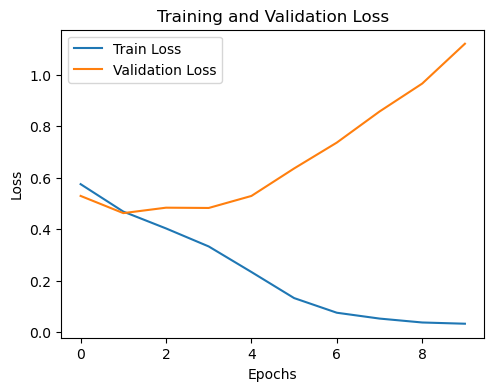

In [1]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot([0.5743,0.4677,0.4023,0.3323,0.2330,0.1317,0.0748,0.0521,0.0369,0.0321], label='Train Loss')
plt.plot([0.5286,0.4618,0.4829,0.4818,0.5285,0.6353,0.7358,0.8565,0.9651,1.1199], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()